In [1]:
import os
import pickle
import sys
import time
from inspect import signature
from queue import Queue
from threading import Event

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tritonclient.grpc as triton
from gwpy.timeseries import TimeSeries, TimeSeriesDict
from rich.progress import Progress
from scipy import signal

from deepcleaner import utils as dcu
from deepcleaner.pipeline import main as pipeline
from hermes.typeo import typeo

%matplotlib inline

In [2]:
def f(**kwargs):
    return kwargs
f.__signature__ = signature(pipeline)
sys.argv = [None, "--typeo"]
config = typeo(f)()
config["num_frames"] = 100
config["inference_rate"] = 750
config

{'witness_data_dir': '/home/muhammed.saleem/deepClean/automated-offline/o3replay_unofficial/live/lldetchar/H1',
 'strain_data_dir': '/home/muhammed.saleem/deepClean/automated-offline/o3replay_unofficial/live/llhoft/H1',
 'write_dir': '/home/alec.gunny/frames/deepcleaned/aggregated-0.5s',
 'kernel_length': 1.0,
 'stride_length': 0.001953125,
 'sample_rate': 4096.0,
 'inference_rate': 750,
 'channels': 'channels.txt',
 'preprocess_pkl': 'ppr.bin',
 'sequence_id': 1001,
 'url': 'localhost:8001',
 'model_name': 'deepclean-stream',
 'model_version': 1,
 'max_latency': 0.5,
 'num_frames': 100,
 'start_first': True,
 'timeout': 3.0,
 'log_file': 'deepclean.latency-0.5.log',
 'verbose': True}

In [3]:
throw_away = config["max_latency"] // config["stride_length"]
stride = int(config["stride_length"] * config["sample_rate"])

with open(config["channels"], "r") as f:
    channels = [i for i in f.read().splitlines() if i]

with open(config["preprocess_pkl"], "rb") as f:
    preproc_config = pickle.load(f)

low = preproc_config["filt_fl"][0] * 2 / config["sample_rate"]
high = preproc_config["filt_fh"][0] * 2 / config["sample_rate"]
sos = signal.butter(
    preproc_config["filt_order"],
    [low, high],
    btype="bandpass",
    output="sos"
)

mean = preproc_config["mean"].astype("float32")
scale = preproc_config["std"].astype("float32")

In [4]:
client = triton.InferenceServerClient(config["url"])
metadata = client.get_model_metadata(config["model_name"])
assert metadata.inputs[0].shape[-1] == stride
input = triton.InferInput(
    name=metadata.inputs[0].name,
    shape=metadata.inputs[0].shape,
    datatype=metadata.inputs[0].datatype
)
metadata

name: "deepclean-stream"
versions: "1"
platform: "ensemble"
inputs {
  name: "stream"
  datatype: "FP32"
  shape: 1
  shape: 21
  shape: 8
}
outputs {
  name: "aggregator"
  datatype: "FP32"
  shape: 1
  shape: 8
}

We need to do streaming inference using Triton, so that our streaming updates always update the same snapshotter state. This means that we have to do inference _asynchronously_, and define a callback function that Triton will use to handle responses from the server in a separate thread

We'll define a simple callback function below that will uncenter the noise prediction by applying the inverse of the preprocessing transformation using the mean and standard deviation of the _strain_ channel. The other key thing we do in the callback is throw away our first few predictions, since those will correspond to predictions for times _before_ the start of the data stream (working on a visualization for this).

In [5]:
noise_predictions = []
error_queue = Queue()
stop_event = Event()

def callback(result, error=None):
    """Simplified version of our real callback function"""

    # make sure nothing went wrong on the server
    if error is not None and not stop_event.is_set():
        stop_event.set()
        error_queue.put(str(error))
    elif stop_event.is_set():
        # if the stop event got set, something already
        # went wrong on the server, and there's no
        # point in catching the same error over and over
        return

    request_id = int(result.get_response().id)

    # we need to get rid of our first few inferences
    # since they technically correspond to predictions
    # from the before the first frame starts!
    if request_id < throw_away:
        return

    # un-center the server's `stride`-sized response
    # and add it to our list of responses
    prediction = result.as_numpy(metadata.outputs[0].name)[0]
    prediction = mean[0] + scale[0] * prediction
    noise_predictions.append(prediction)

Now we're ready to do inference. We'll load in one frame at a time, then iterate through each frame in `stride`-sized chunks which will update the snapshot state on the server.

In [6]:
strains = np.array([])
updates_per_frame = int(config["sample_rate"] // stride)
total_updates = updates_per_frame * (config["num_frames"] + 1)

# open a gRPC streaming connection to the server
with client, Progress() as progress:
    client.start_stream(callback=callback)
    task_id = progress.add_task("Sending requests", total=total_updates)

    fnames = os.listdir(config["witness_data_dir"])[:config["num_frames"] + 1]
    for n, fname in enumerate(fnames):
        # read the witness data frame file
        witness_fname = os.path.join(config["witness_data_dir"], fname)
        witness_dict = TimeSeriesDict.read(witness_fname, channels[1:])

        # preprocess it by resampling, stacking into an array,
        # then centering the data per-channel
        witnesses = []
        for channel in channels[1:]:
            witness = witness_dict[channel]
            if witness.sample_rate.value != config["sample_rate"]:
                witness.resample(config["sample_rate"])
            witnesses.append(witness.value)
                
        witnesses = np.stack(witnesses).astype("float32")[None]
        witnesses = (witnesses - mean[1:]) / scale[1:]

        # load the strain data and just add it
        # to our running array keeping track of that
        strain_fname = os.path.join(
            config["strain_data_dir"], fname.replace("Detchar", "HOFT")
        )
        strain = TimeSeries.read(strain_fname, channels[0])
        if strain.sample_rate.value != config["sample_rate"]:
            strain.resample(config["sample_rate"])[0]
        if n < (len(fnames) - 1):
            strains = np.append(strains, strain)

        # send `stride`-sized updates to the snapshot
        # model on the server
        for i in range(updates_per_frame):

            # check to make sure everything is still
            # ok on the server
            if stop_event.is_set():
                err = error_queue.get_nowait()
                raise RuntimeError(err)

            # update the input protobuf with the new data
            update = witnesses[:, :, stride * i : stride * (i + 1)]
            input.set_data_from_numpy(update)

            # make an asynchronous request using the
            # current update
            request_id = n * updates_per_frame + i
            client.async_stream_infer(
                config["model_name"],
                model_version=str(config["model_version"]),
                inputs=[input],
                request_id=str(request_id),
                sequence_id=config["sequence_id"],
                sequence_start=request_id == 0,
                sequence_end=request_id == total_updates - 1
            )

            # sleep to keep from overwhelming the network
            progress.update(task_id, advance=1)
            time.sleep(1 / config["inference_rate"])

noise_predictions = np.concatenate(noise_predictions)
noise_predictions = noise_predictions[:stride * updates_per_frame * (len(fnames) - 1)]

Output()

Sending requests ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00

In [7]:
data = np.stack([strains, noise_predictions])
cleaned = np.array([])
for strain, noise in np.split(data, 10, axis=-1):
    strain = signal.sosfiltfilt(sos, strain)
    noise = signal.sosfiltfilt(sos, noise)

    clean = strain - noise
    cleaned = np.append(cleaned, clean)

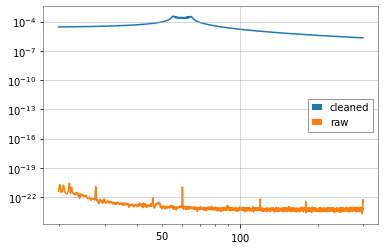

In [8]:
fig, ax = plt.subplots()

def get_asd(ts):
    ts = TimeSeries(ts, sample_rate=config["sample_rate"])
    asd = ts.asd(fftlength=10, overlap=0.5, method="median")
    return asd.crop(20, 300)

ax.loglog(get_asd(cleaned), label="cleaned")
ax.loglog(get_asd(strains), label="raw")
ax.legend()
fig.show()